<a href="https://colab.research.google.com/github/hkhong72/big_data/blob/main/221102_3Chap20_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, # 수평 대칭 이미지를 50%확률로 만들어 추가
                                  width_shift_range=0.1, # 전체 크기의 15% 범위에서 좌우로 이동
                                  height_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255) # 테스트 할 데이터는 변형시키면 안됨
train_generator = train_datagen.flow_from_directory('data/data/train',
                                                   target_size=(150, 150),
                                                   batch_size=5,
                                                   class_mode='binary')
test_generator = test_datagen.flow_from_directory('data/data/test',
                                                   target_size=(150, 150),
                                                   batch_size=5,
                                                   class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
# 모델새로만들기
transfer_model = VGG16(weights='imagenet', include_top=False, 
                       #맨마지막을날리고 우리껄 쌓음(파인튜닝)
                       input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64, activation='relu'))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1, activation='sigmoid'))
finetune_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# 모델 실행 옵션 설정
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습 조기 중단 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# 모델 실행
history = finetune_model.fit(train_generator,epochs=100,
                   validation_data=test_generator,
                   callbacks=[early_stopping])

Epoch 1/100
32/32 [==============================] - 15s 460ms/step - loss: 0.6760 - accuracy: 0.5562 - val_loss: 0.5515 - val_accuracy: 0.7250
Epoch 2/100
32/32 [==============================] - 15s 474ms/step - loss: 0.4961 - accuracy: 0.7500 - val_loss: 0.4269 - val_accuracy: 0.8417
Epoch 3/100
32/32 [==============================] - 15s 489ms/step - loss: 0.4197 - accuracy: 0.8500 - val_loss: 0.3714 - val_accuracy: 0.8667
Epoch 4/100
32/32 [==============================] - 15s 467ms/step - loss: 0.3717 - accuracy: 0.8438 - val_loss: 0.3152 - val_accuracy: 0.9083
Epoch 5/100
32/32 [==============================] - 15s 467ms/step - loss: 0.3478 - accuracy: 0.8562 - val_loss: 0.2921 - val_accuracy: 0.9167
Epoch 6/100
32/32 [==============================] - 15s 470ms/step - loss: 0.3087 - accuracy: 0.8687 - val_loss: 0.2519 - val_accuracy: 0.9500
Epoch 7/100
32/32 [==============================] - 15s 470ms/step - loss: 0.2845 - accuracy: 0.8875 - val_loss: 0.2330 - val_accuracy:

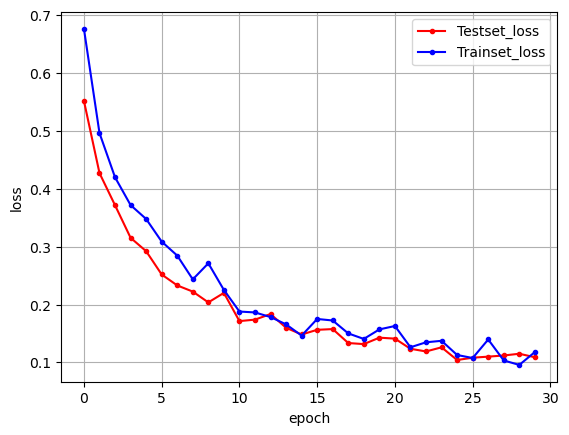

In [ ]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()